<a href="https://colab.research.google.com/github/ayushpratapno1/image-classification/blob/main/classification_real_vs_ai_generated_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
# GPU configuration
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s)")
    else:
        print("No GPU found, using CPU")
except Exception as e:
    print(f"GPU configuration error: {e}")

# Load image dataset

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/', image_size=(224, 224), batch_size=32)

Found 31 files belonging to 4 classes.


# Visualizing  of sample set of images


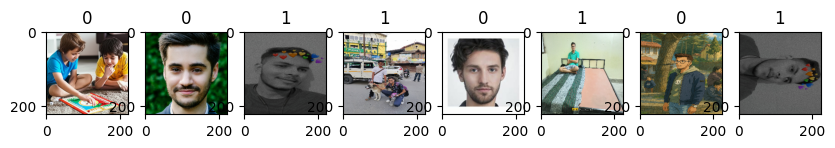

In [ ]:
data_it = data.as_numpy_iterator()
batch = data_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Normalizing the dataset for faster computation
To Normalize the data set I am # scaling pixel values to the range [0, 1]


In [ ]:
data = data.map(lambda x, y : (x/255, y))

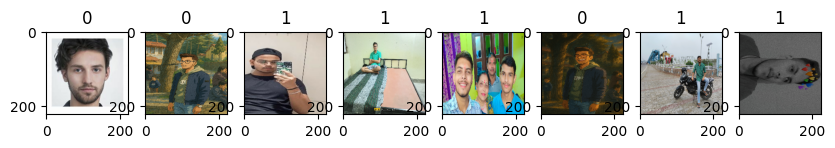

In [ ]:
# Showing scaled sample of images
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])


# Splitting Data to Train, Test, Validation

In [ ]:
# Splitting Data to Train, Test, Validation
# Adjusted split for very small dataset size - ideally, use a larger dataset
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.2)    # 20% for validation
test_size = len(data) - train_size - val_size  # 10% for testing


cv_size = int(len(data) * 0.2)

train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size + cv_size).take(test_size)

print("Train: ",len(train))
print("Test: ", len(test))
print("Val: ",len(cv))

Train:  0
Test:  1
Val:  0


# Model Building
I have used pretrained ResNet50 as base model without freezing it's layers

In [ ]:
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define the model using the Functional API
input_tensor = tf.keras.Input(shape=(224, 224, 3))
x = base_model(input_tensor)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
output_tensor = layers.Dense(1, activation='sigmoid')(x) # Adjust the final layer according to your task

model = Model(inputs=input_tensor, outputs=output_tensor)

In [ ]:
# Overview of the Model
model.summary()

Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,312,129 (188.11 MB)

 Trainable params: 49,258,497 (187.91 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [ ]:
# Learning rate scheduler
initial_learning_rate = 0.001
def lr_scheduler(epoch, lr):
    return lr * 0.95
lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)

# Compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Data Augumentation

In [ ]:
# Data Augmentation in the pipeline
def augment_data(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    return x, y
train_augmented = data.map(augment_data)



# Model Training

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_augmented, validation_data=cv, epochs=10, callbacks=[lr_schedule, early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 156s 156s/step - accuracy: 0.6129 - loss: 0.7815 - learning_rate: 9.5000e-04
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9355 - loss: 0.1934 - learning_rate: 9.0250e-04
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1373 - learning_rate: 8.5737e-04
Epoch 4/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0854 - learning_rate: 8.1451e-04
Epoch 5/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9677 - loss: 0.0808 - learning_rate: 7.7378e-04
Epoch 6/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0328 - learning_rate: 7.3509e-04
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0188 - learning_rate: 6.9834e-04
Epoch 8/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0418 - learning_rate: 6.6342e-04
Epoch 9/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0131 - learning_rate: 6.3025e-04
Epoch 10/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0097 - learning_rate: 5.9874e-04


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4194 - loss: 0.8905
Test Accuracy: 41.94%






# Plotting Model Accuracy & Loss

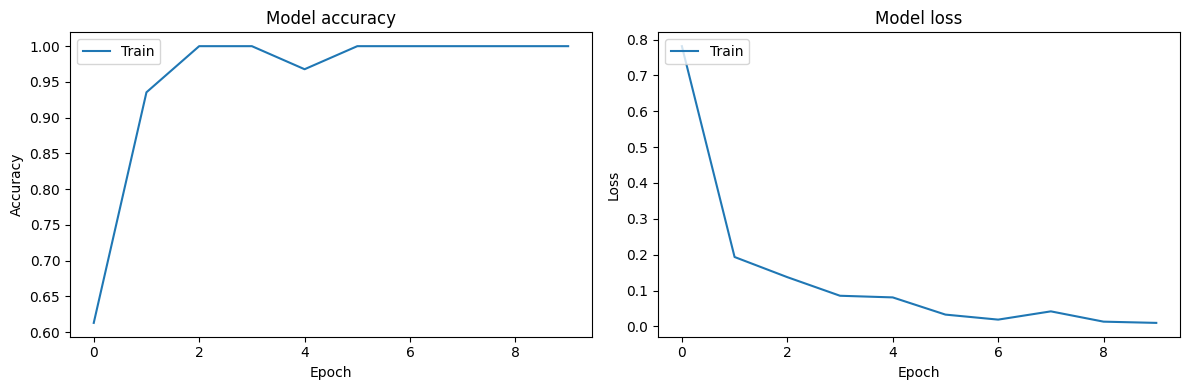

Test Accuracy: 41.94%
Test Loss: 0.8905


In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Precision, Recall & Accuracy

In [ ]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')


Precision: 0.0, Recall: 0.0, Accuracy: 0.4193548262119293


**Save & Loaded The Model**

In [ ]:
import os

# Create the 'model' directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# Assuming 'model' is your Keras model
model.save('model/ai_imageclassifier.keras')

loaded_model = tf.keras.models.load_model('model/ai_imageclassifier.keras')

# Model Prediction On Any Single Image

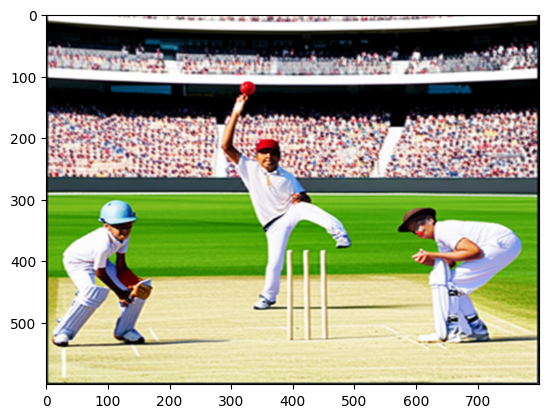

In [ ]:
# Load the image
image_path = '/three boys play.png'

try:
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not read the image from {image_path}")
    img = cv2.resize(img, (800, 600))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

except Exception as e:
    print(f"Error: {e}")


In [ ]:
resize = tf.image.resize(img, (224, 224))
y_pred = model.predict(np.expand_dims(resize/255, 0))
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


array([[0.27917364]], dtype=float32)

In [ ]:
if y_pred > 0.5:
    print(f'Predicted class: REAL')
else:
    print(f'Predicted class: AI')

Predicted class: AI


# Classification Report & Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


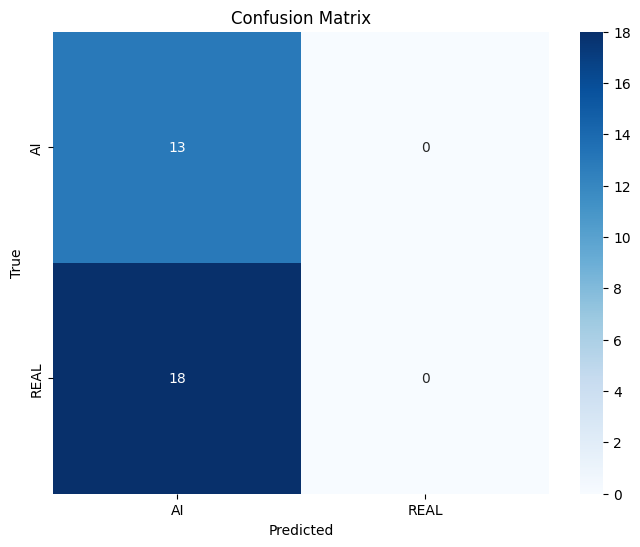

Classification Report:
               precision    recall  f1-score   support

          AI       0.42      1.00      0.59        13
        REAL       0.00      0.00      0.00        18

    accuracy                           0.42        31
   macro avg       0.21      0.50      0.30        31
weighted avg       0.18      0.42      0.25        31



In [ ]:
# Evaluate the model on the test set
y_true = []
y_pred_probs = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    y_pred_probs.extend(model.predict(X).flatten())

# Convert probabilities to binary predictions
y_pred = np.array(y_pred_probs) > 0.5

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=['AI', 'REAL'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'REAL'], yticklabels=['AI', 'REAL'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display Classification Report
print("Classification Report:\n", class_report)


Path to dataset files: /kaggle/input/ai-generated-images-vs-real-images

Dataset structure:
ai-generated-images-vs-real-images/
  RealArt/
    RealArt/
      portrait-smiling-middle-aged-african-260nw-2088822202.jpg
      A142xwh4GVL._AC_UF8941000_QL80_.jpg
      -man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpg
      people-strategy_1200x700.jpg
      360_F_606797008_rGPPk6bFWDQydnX7g7w1w9dVVZ4mD22J.jpg
      ... and 431 more files
  AiArtData/
    AiArtData/
      Various-AI-portraits-generated-by-Fotor.jpg
      images77.jpg
      1000_F_563719058_JXnzcPV4GRpWqmF5sqnqmbJ7ow3ca3DS.jpg
      MidJourney-content-policy-1024x576.jpg
      an-ai-jungle-landscape-made-by-ai-landscape-generator.jpg
      ... and 534 more files
No GPU found, using CPU
Found 971 files belonging to 2 classes.
Found classes: ['AiArtData', 'RealArt']
Total batches: 31


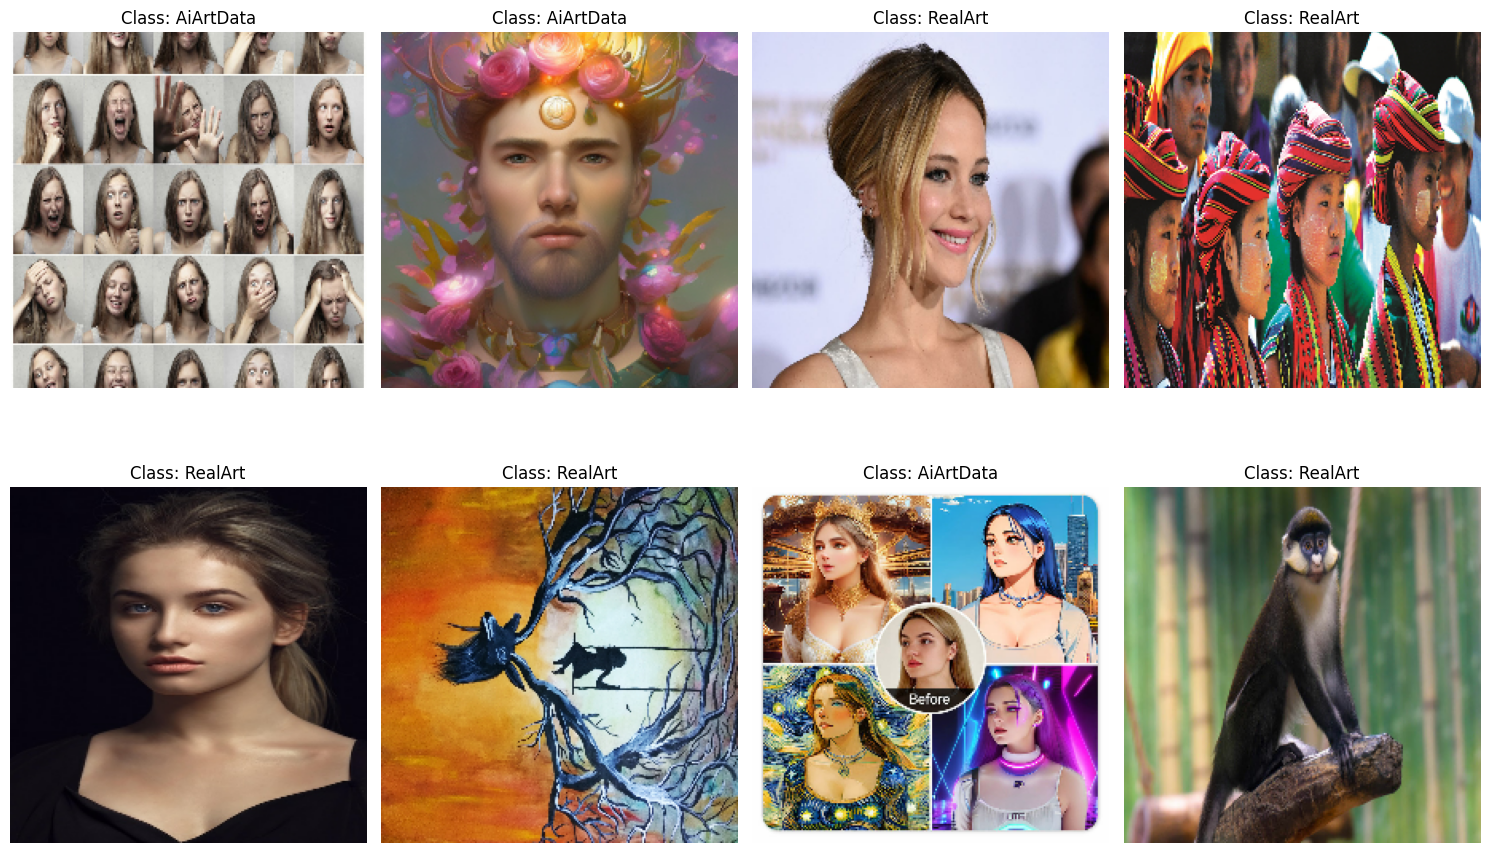

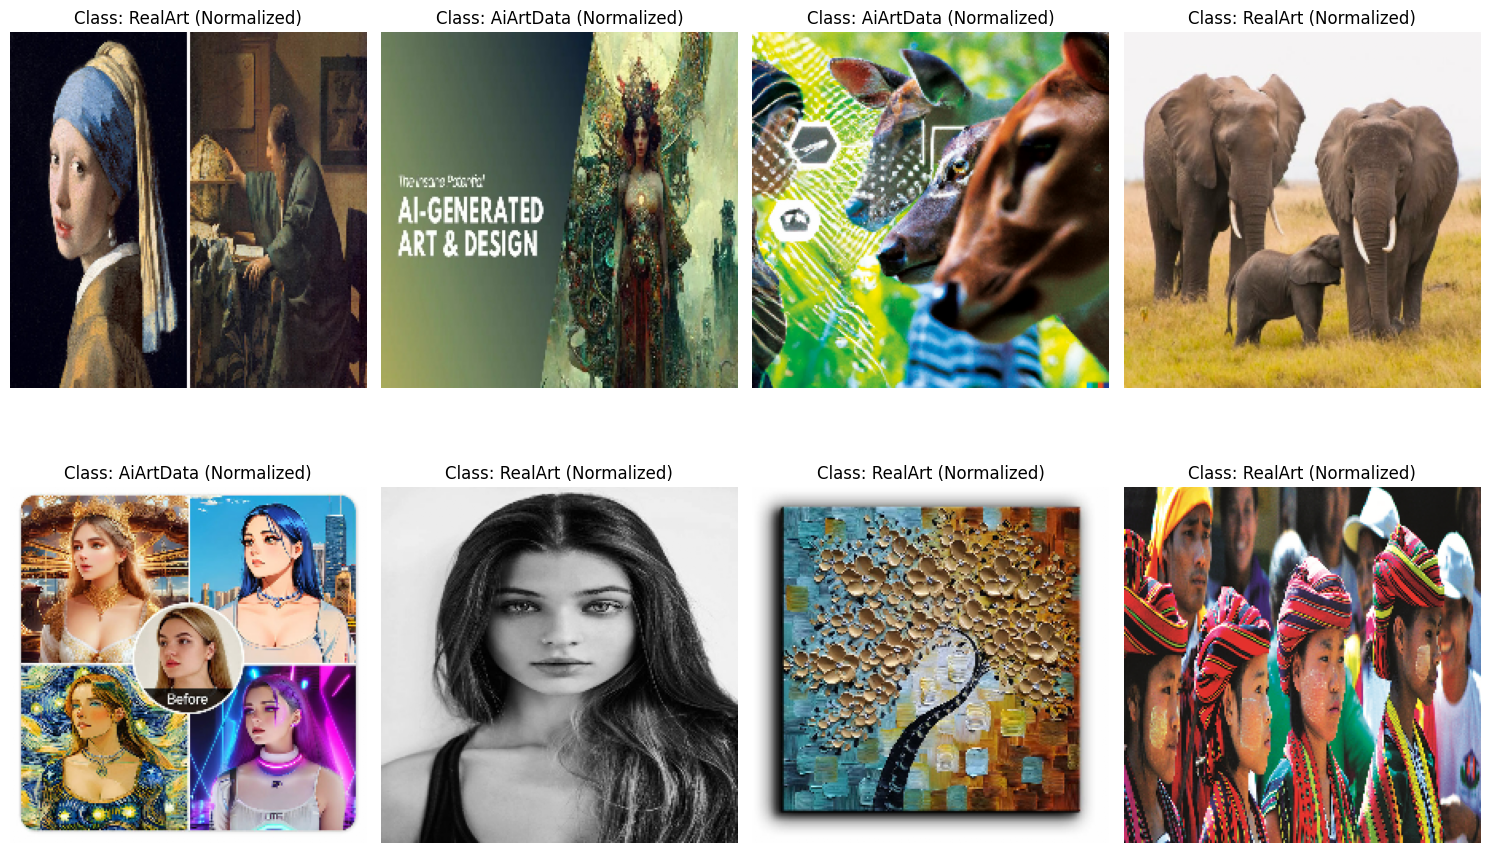

Train batches: 21
Validation batches: 6
Test batches: 4
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,778,625 (94.52 MB)

 Trainable params: 10,117,121 (38.59 MB)

 Non-trainable params: 14,661,504 (55.93 MB)

Starting model training...

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5159 - loss: 0.8851 - precision: 0.4682 - recall: 0.6656
Epoch 1: val_accuracy improved from -inf to 0.42708, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 256s 11s/step - accuracy: 0.5164 - loss: 0.8826 - precision: 0.4691 - recall: 0.6650 - val_accuracy: 0.4271 - val_loss: 0.7157 - val_precision: 0.4241 - val_recall: 1.0000 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6013 - loss: 0.7054 - precision: 0.5382 - recall: 0.6822
Epoch 2: val_accuracy improved from 0.42708 to 0.57292, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 221s 10s/step - accuracy: 0.6028 - loss: 0.7037 - precision: 0.5403 - recall: 0.6827 - val_accuracy: 0.5729 - val_loss: 0.6868 - val_precision: 

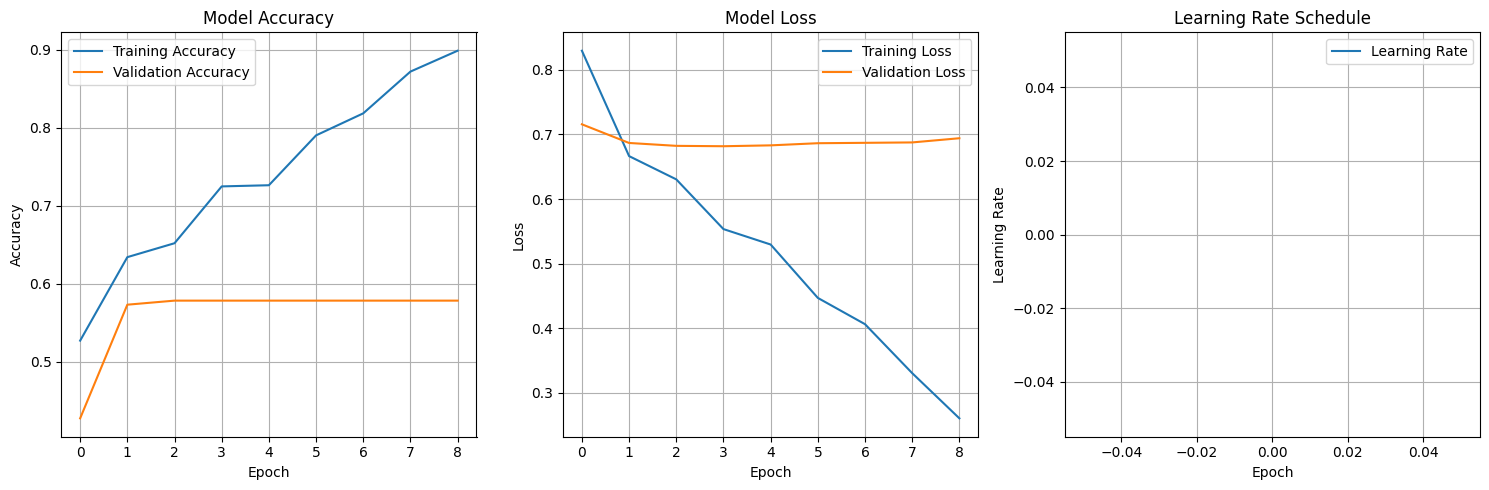

Calculating comprehensive metrics...


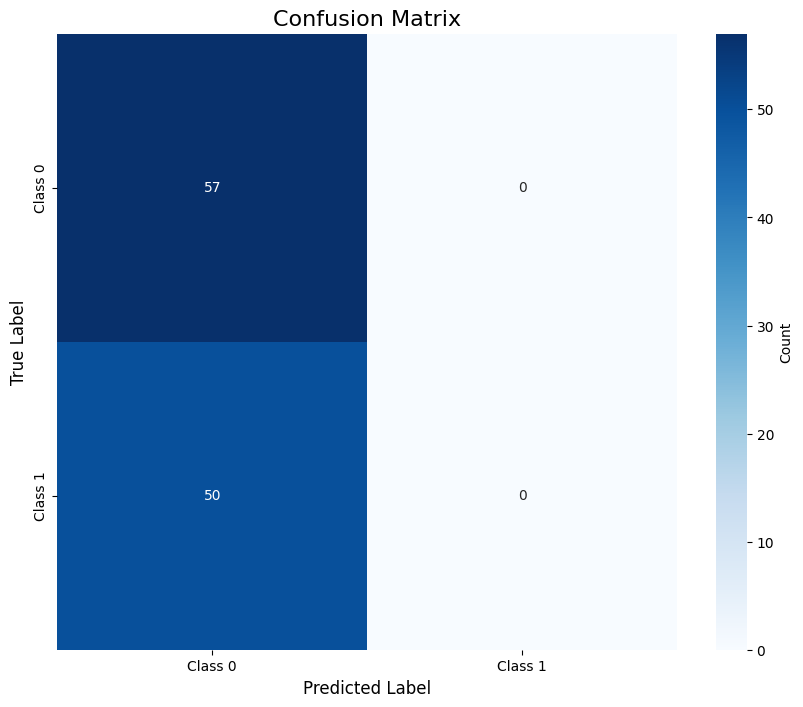

Confusion Matrix:
[[57  0]
 [50  0]]

Classification Report:
              precision    recall  f1-score   support

     Class 0     0.5327    1.0000    0.6951        57
     Class 1     0.0000    0.0000    0.0000        50

    accuracy                         0.5327       107
   macro avg     0.2664    0.5000    0.3476       107
weighted avg     0.2838    0.5327    0.3703       107


Additional Metrics:
Sensitivity (Recall): 0.0000
Specificity: 1.0000
F1-Score: 0.0000
Model saved to model/ai_imageclassifier_improved.keras
Model loaded successfully!


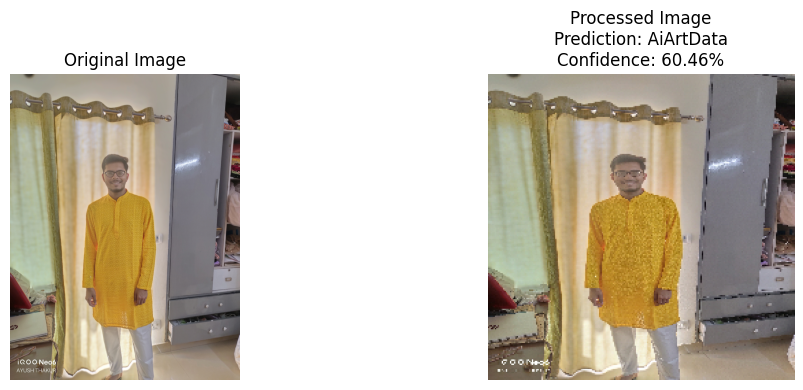

Prediction: AiArtData
Confidence: 60.46%
Raw probability: 0.3954
Model training and evaluation completed successfully!


In [ ]:
# Loading Required Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import os
import kagglehub

# Download dataset directly from Kaggle
print("Downloading dataset from Kaggle...")
dataset_path = kagglehub.dataset_download("cashbowman/ai-generated-images-vs-real-images")
print("Path to dataset files:", dataset_path)

# Explore dataset structure
print("\nDataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

# GPU configuration
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s)")
    else:
        print("No GPU found, using CPU")
except Exception as e:
    print(f"GPU configuration error: {e}")

# Load image dataset from downloaded path
# The dataset likely has subdirectories for each class
data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),  # Better size for ResNet50
    batch_size=32,
    shuffle=True,
    seed=123
)

# Get class names
class_names = data.class_names
print(f"Found classes: {class_names}")
print(f"Total batches: {len(data)}")
# Visualizing sample set of images
plt.figure(figsize=(15, 10))
data_it = data.as_numpy_iterator()
batch = data_it.next()

for idx in range(min(8, len(batch[0]))):
    plt.subplot(2, 4, idx + 1)
    plt.imshow(batch[0][idx].astype(int))
    plt.title(f"Class: {class_names[int(batch[1][idx])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Normalizing the dataset for faster computation
# Scaling pixel values to the range [0, 1]
data = data.map(lambda x, y: (x/255.0, y))

# Showing scaled sample of images
plt.figure(figsize=(15, 10))
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()

for idx in range(min(8, len(batch[0]))):
    plt.subplot(2, 4, idx + 1)
    plt.imshow(batch[0][idx])
    plt.title(f"Class: {class_names[int(batch[1][idx])]} (Normalized)")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Splitting Data to Train, Test, Validation with better ratios
total_batches = len(data)
train_size = int(total_batches * 0.7)  # 70% for training
val_size = int(total_batches * 0.2)    # 20% for validation
test_size = total_batches - train_size - val_size  # 10% for testing

# Ensure minimum dataset size
if total_batches < 10:
    print("Warning: Dataset is very small. Consider using more data for better results.")
    print("Adjusting split sizes due to small dataset.")
    train_size = int(total_batches * 0.8)
    val_size = 0
    test_size = total_batches - train_size


train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

print(f"Train batches: {len(train)}")
print(f"Validation batches: {len(val)}")
print(f"Test batches: {len(test)}")

# Data Augmentation (applied only to training data)
def augment_data(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    return x, y

# Apply augmentation only to training data
train_augmented = train.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize data pipeline
train_augmented = train_augmented.cache().prefetch(tf.data.AUTOTUNE)
val = val.cache().prefetch(tf.data.AUTOTUNE)
test = test.cache().prefetch(tf.data.AUTOTUNE)

# Model Building with improved architecture
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Fine-tune the last few layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Model summary
model.summary()

# Improved learning rate scheduler
initial_learning_rate = 0.0001
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1).numpy() # Convert tensor to float

lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)

# Compile model with better optimizer settings
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Enhanced callbacks
callbacks = [
    lr_schedule,
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Model Training
print("Starting model training...")
history = model.fit(
    train_augmented,
    validation_data=val,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# Evaluate the model on the test set
print("Evaluating model on test set...")
if len(test) > 0:
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=1)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
else:
    print("Test dataset is empty. Skipping evaluation.")
    test_loss, test_accuracy, test_precision, test_recall = None, None, None, None


# Plotting Model Accuracy & Loss with improved visualization
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot learning rate
plt.subplot(1, 3, 3)
plt.plot(history.history.get('lr', []), label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Comprehensive Model Evaluation
print("Calculating comprehensive metrics...")

# Collect all predictions and true labels
y_true = []
y_pred_probs = []

if len(test) > 0:
    for batch in test.as_numpy_iterator():
        X, y = batch
        predictions = model.predict(X, verbose=0)
        y_true.extend(y)
        y_pred_probs.extend(predictions.flatten())

    # Convert probabilities to binary predictions
    y_pred = np.array(y_pred_probs) > 0.5

    # Define target names for binary classification based on the actual classes
    # Assuming 'AI' is class 0 and 'REAL' is class 1 based on the error and dataset output
    binary_target_names = ['Class 0', 'Class 1'] # Replace with actual class names if needed

    # Confusion Matrix
    # Specify labels to match the binary output (0 and 1)
    conf_mat = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Classification Report
    # Specify labels and target_names for binary classification
    class_report = classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        target_names=binary_target_names,
        digits=4,
        zero_division=0 # Handle cases with zero division
    )

    # Plot Enhanced Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_mat,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=binary_target_names,
        yticklabels=binary_target_names,
        cbar_kws={'label': 'Count'}
    )
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

    # Display results
    print("Confusion Matrix:")
    print(conf_mat)
    print("\nClassification Report:")
    print(class_report)

    # Calculate additional metrics
    if conf_mat.shape == (2, 2): # Check if confusion matrix is 2x2 for binary classification
      tn, fp, fn, tp = conf_mat.ravel()
      specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
      sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
      # Recalculate F1 score using calculated precision and recall from the report if needed,
      # or use the test_precision and test_recall from model.evaluate if available and accurate
      # For now, using the test_precision and test_recall from model.evaluate
      f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else 0

      print(f"\nAdditional Metrics:")
      print(f"Sensitivity (Recall): {sensitivity:.4f}")
      print(f"Specificity: {specificity:.4f}")
      print(f"F1-Score: {f1_score:.4f}")
    else:
        print("\nCannot calculate additional metrics with non-binary confusion matrix.")

else:
    print("Test dataset is empty. Skipping comprehensive metrics calculation.")


# Save the final model
model_save_path = 'model'
os.makedirs(model_save_path, exist_ok=True)
model.save(f'{model_save_path}/ai_imageclassifier_improved.keras')
print(f"Model saved to {model_save_path}/ai_imageclassifier_improved.keras")

# Load model (demonstration)
loaded_model = tf.keras.models.load_model(f'{model_save_path}/ai_imageclassifier_improved.keras')
print("Model loaded successfully!")

# Enhanced Single Image Prediction Function
def predict_single_image(image_path, model, class_names):
    """
    Predict class for a single image with proper error handling
    """
    try:
        # Load and preprocess image
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Could not read image from {image_path}")

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display original image
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.title('Original Image')
        plt.axis('off')

        # Resize and normalize for prediction
        img_resized = tf.image.resize(img_rgb, (224, 224))
        img_normalized = img_resized / 255.0
        img_batch = np.expand_dims(img_normalized, 0)

        # Make prediction
        prediction_prob = model.predict(img_batch, verbose=0)[0][0]
        # Assuming class_names[0] is the negative class and class_names[1] is the positive class for binary classification
        predicted_class_name = class_names[1] if prediction_prob > 0.5 else class_names[0]
        confidence = prediction_prob if prediction_prob > 0.5 else 1 - prediction_prob

        # Display processed image
        plt.subplot(1, 2, 2)
        plt.imshow(img_normalized)
        plt.title(f'Processed Image\nPrediction: {predicted_class_name}\nConfidence: {confidence:.2%}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Prediction: {predicted_class_name}")
        print(f"Confidence: {confidence:.2%}")
        print(f"Raw probability: {prediction_prob:.4f}")

        return predicted_class_name, confidence

    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

# Example usage (update the path to your image)
image_path = '/content/IMG_20250304_114346.jpg'  # Update this path
if os.path.exists(image_path):
    # Pass the original class_names to the prediction function
    predict_single_image(image_path, model, class_names)
else:
    print(f"Test image not found at {image_path}")

print("Model training and evaluation completed successfully!")

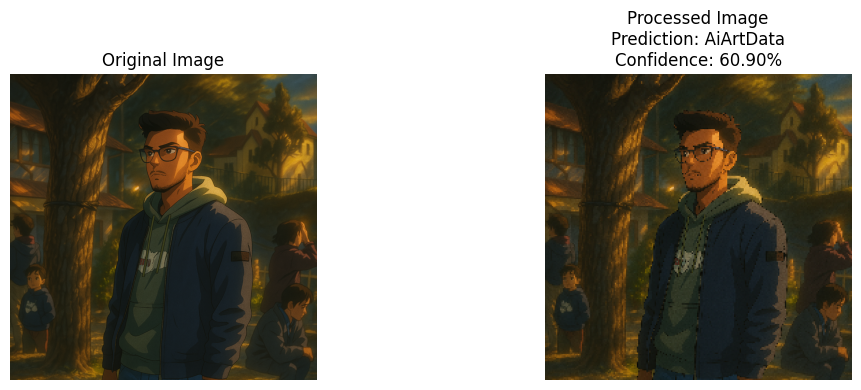

Prediction: AiArtData
Confidence: 60.90%
Raw probability: 0.3910
Model training and evaluation completed successfully!


In [ ]:
# Example usage (update the path to your image)
image_path = '/content/ChatGPT Image Apr 1, 2025, 12_31_16 AM.png'  # Update this path
if os.path.exists(image_path):
    # Pass the original class_names to the prediction function
    predict_single_image(image_path, model, class_names)
else:
    print(f"Test image not found at {image_path}")

print("Model training and evaluation completed successfully!")